In [1]:
import os
import sys
sys.path.append(os.getcwd())

import time
import json
import datetime
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy

from grace.camera import LeftEyeCapture, RightEyeCapture
from grace.control import ROSMotorClient
from grace.utils import *

In [3]:
left_cam = LeftEyeCapture()
right_cam = RightEyeCapture()

In [4]:
calib_params = load_json('config/calib/calib_params.json')

In [5]:
left_center_x = round(calib_params['left_eye']['x_center'])
left_center_y = round(calib_params['left_eye']['y_center'])

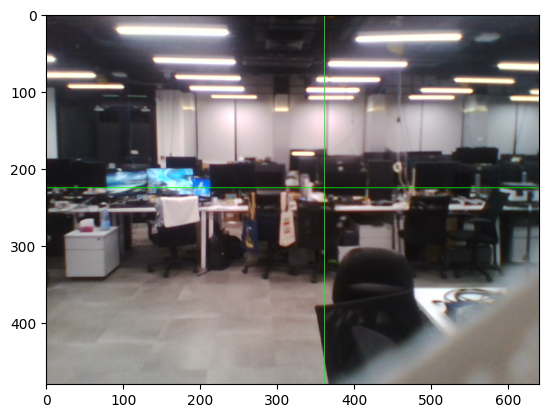

In [6]:
frame = left_cam.frame
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = cv2.line(frame, (left_center_x , 0), (left_center_x , 480), (0,255,0))
frame = cv2.line(frame, (0, left_center_y), (640, left_center_y ), (0,255,0))
plt.imshow(frame)

In [7]:
left_center_x = round(calib_params['left_eye']['x_center'])
left_center_y = round(calib_params['left_eye']['y_center'])

frame = cv2.line(frame, (left_center_x , 0), (left_center_x , 480), (0,255,0))
frame = cv2.line(frame, (0, left_center_y), (640, left_center_y ), (0,255,0))

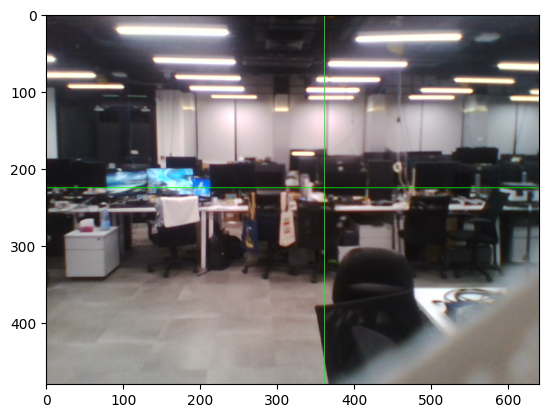

In [8]:
plt.imshow(frame)

In [9]:
def crop_image(image, x, y):
    # Calculate the coordinates for cropping
    img = copy.deepcopy(image)
    x_start = x - 32
    y_start = y - 32
    x_end = x_start + 64
    y_end = y_start + 64

    # Crop the image
    cropped_image = img[y_start:y_end, x_start:x_end]

    return cropped_image

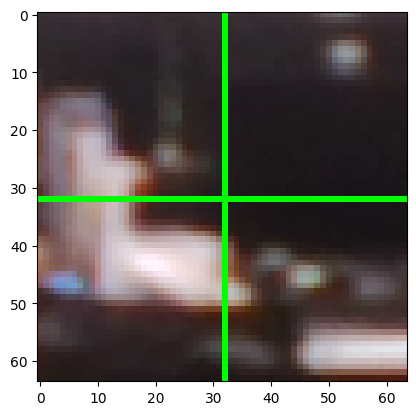

In [10]:
crop_frame = crop_image(frame, left_center_x , left_center_y)
plt.imshow(crop_frame)

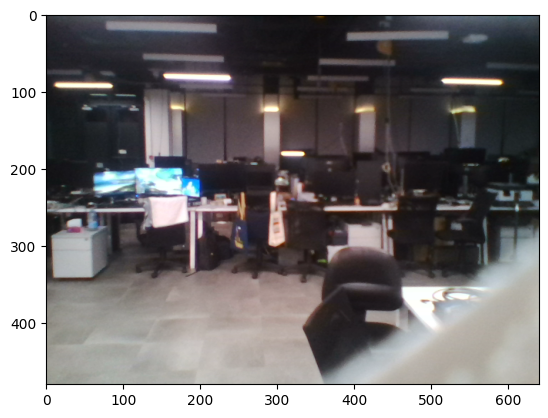

In [66]:
frame = left_cam.frame
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

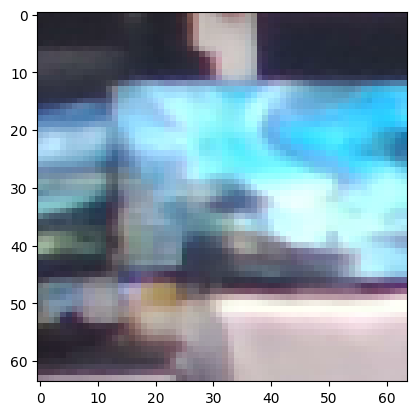

In [12]:
target_frame = crop_image(frame, 150, 220)
plt.imshow(target_frame)

# New one

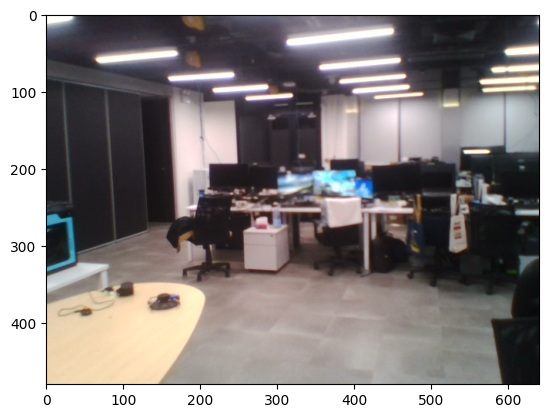

In [28]:
frame = left_cam.frame
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

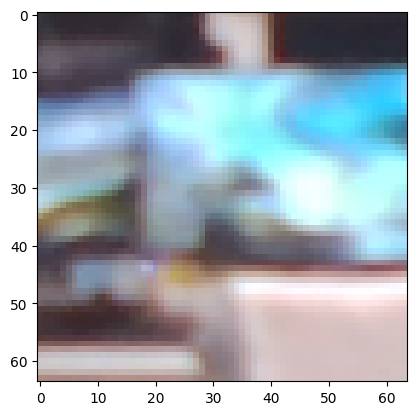

In [29]:
crop_frame = crop_image(frame, left_center_x , left_center_y)
plt.imshow(crop_frame)

# Sift

In [52]:
sift = cv2.SIFT_create()
matcher = cv2.BFMatcher()

In [53]:
frame = cv2.line(frame, (left_center_x , 0), (left_center_x , 480), (0,255,0))
frame = cv2.line(frame, (0, left_center_y), (640, left_center_y ), (0,255,0))

In [54]:
gray_target_frame = cv2.cvtColor(target_frame, cv2.COLOR_RGB2GRAY)
gray_crop_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

Distance to calibrated center_x: 12.865570068359375
Distance to calibrated center_y: -11.628128051757812


(-0.5, 703.5, 479.5, -0.5)

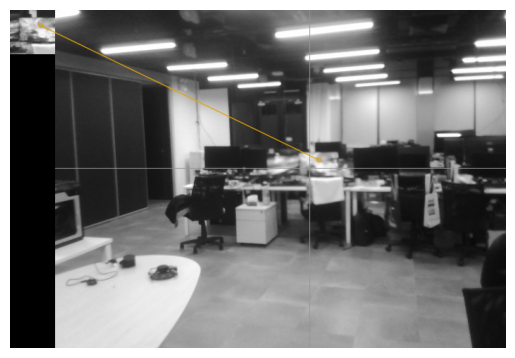

In [55]:
keypoints1, descriptors1 = sift.detectAndCompute(gray_target_frame, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray_crop_frame, None)

matches = matcher.match(descriptors1, descriptors2)
sorted_matches = sorted(matches, key=lambda x: x.distance)

# Select the top match
top_match = sorted_matches[0]

# Retrieve keypoint indices from the top match
query_idx = top_match.queryIdx
train_idx = top_match.trainIdx

# Retrieve corresponding keypoints
keypoint1 = keypoints1[query_idx]
keypoint2 = keypoints2[train_idx]

distance_to_optical_center_x = keypoint2.pt[0]-left_center_x
distance_to_optical_center_y = keypoint2.pt[1]-left_center_y

# Print the distance
print("Distance to calibrated center_x:", distance_to_optical_center_x)
print("Distance to calibrated center_y:", distance_to_optical_center_y)

img3 = cv2.drawMatches(gray_target_frame,keypoints1,gray_crop_frame,keypoints2,sorted_matches[:1],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.axis('off')


In [56]:
keypoint1.pt

(43.125762939453125, 22.951181411743164)

In [58]:
keypoint1.pt[0] - 31

12.125762939453125

In [59]:
keypoint1.pt[1] - 31

-8.048818588256836

In [37]:
keypoint2.pt

(359.7109680175781, 217.7605743408203)

In [34]:
left_center_x

361

In [36]:
left_center_y

225

# Function

In [127]:
class KeypointDetection(object):
    
    def __init__(self, crop_size=64):
        self.crop_size = crop_size
        self.sift = cv2.SIFT_create()
        self.matcher = cv2.BFMatcher()
        self.calib_params = load_json('config/calib/calib_params.json')
    
    def crop_image(self, image, x, y):
        # Calculate the coordinates for cropping
        img = copy.deepcopy(image)
        x_start = x - int(self.crop_size/2)
        y_start = y - int(self.crop_size/2)
        x_end = x_start + int(self.crop_size)
        y_end = y_start + int(self.crop_size)

        # Crop the image
        cropped_image = img[y_start:y_end, x_start:x_end]

        return cropped_image
    
    def assign_target(self, image, x, y):
        self.target_image = self.crop_image(image, x, y)
    
    def distance_from_target(self, new_image, eye):
        """After motor movement
        """
        self.new_image = new_image
        self.gray_target_image = cv2.cvtColor(self.target_image, cv2.COLOR_RGB2GRAY)
        self.gray_new_image = cv2.cvtColor(self.new_image, cv2.COLOR_RGB2GRAY)
        
        keypoints1, descriptors1 = self.sift.detectAndCompute(self.gray_target_image, None)
        keypoints2, descriptors2 = self.sift.detectAndCompute(self.gray_new_image, None)

        matches = self.matcher.match(descriptors1, descriptors2)
        sorted_matches = sorted(matches, key=lambda x: x.distance)

        # Select the top match
        top_match = sorted_matches[0]

        # Retrieve keypoint indices from the top match
        query_idx = top_match.queryIdx  # target
        train_idx = top_match.trainIdx

        # Retrieve corresponding keypoints
        keypoint1 = keypoints1[query_idx]  # target
        keypoint2 = keypoints2[train_idx]

        distance_to_cal_center_x = keypoint2.pt[0]-(keypoint1.pt[0]-self.crop_size/2)-self.calib_params[eye]['x_center']
        distance_to_cal_center_y = self.calib_params[eye]['y_center']-(self.crop_size/2-keypoint1.pt[1])-keypoint2.pt[1]

        magnitude = np.sqrt(distance_to_cal_center_x**2 + distance_to_cal_center_y**2)
        
        # Plotting
        self.disp_img = cv2.drawMatches(self.gray_target_image,keypoints1,self.gray_new_image,keypoints2,sorted_matches[:1],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        
        return magnitude, distance_to_cal_center_x, distance_to_cal_center_y

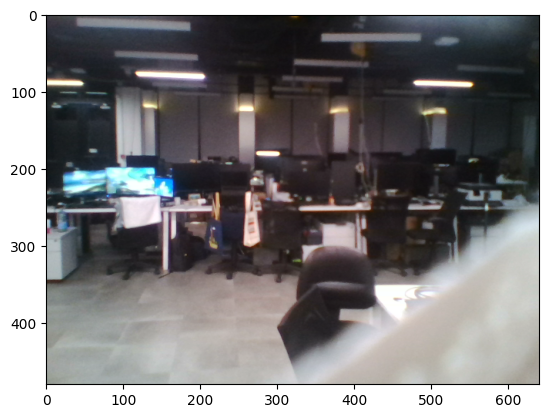

In [104]:
target_frame = left_cam.frame
target_frame = cv2.cvtColor(target_frame, cv2.COLOR_BGR2RGB)
plt.imshow(target_frame)

In [128]:
kp = KeypointDetection()

In [129]:
old_frame = copy.deepcopy(target_frame)

In [130]:
kp.assign_target(old_frame, 110, 210)

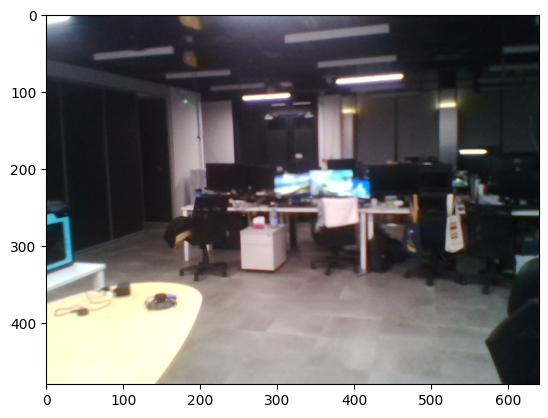

In [131]:
frame = left_cam.frame
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

In [132]:
kp.distance_from_target(frame, 'left_eye')

(16.292118204301246, 10.81914367675779, 12.181101989746082)

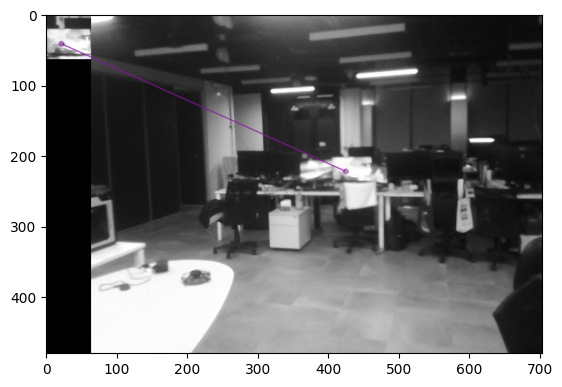

In [133]:
plt.imshow(kp.disp_img)